# Supervised learning on Pulse Curves data 

In [6]:
import os 
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# The directory in which you have placed the following code
os.chdir('W:/Bureau/these/planktonPipeline/')

from keras_utils import cnn_model, plot_losses, multi_input_gen, fit_gen, moving_average_batch
from extract_Pulse_curves.from_cytoclus_to_imgs import extract_imgs
from extract_Pulse_curves.cnn_functions import imgs_train_test_valid_split, nb_available_imgs

# Where to look the data at and where to write treated data: Change with yours
data_source = 'W:/Bureau/these/donnees_oceano/new_process_FLR6'
data_destination = 'W:/Bureau/these/data'

root_dir = "W:/Bureau/these/data/curves"
seed = 42

L:\ProgramData\Anaconda4\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Apply a moving average to the image to reduce the signal/white pixels ratio

In [5]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

Original image


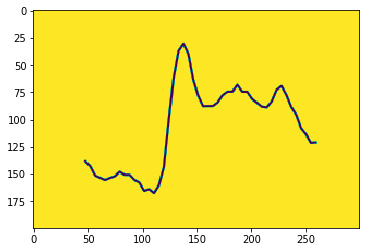

Applying a 10 pixels long Moving Average Filter


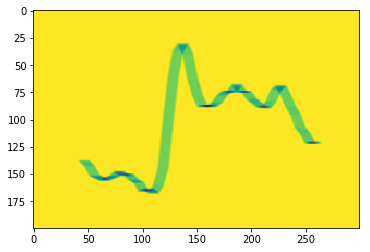

Applying a 40 pixels long Moving Average Filter


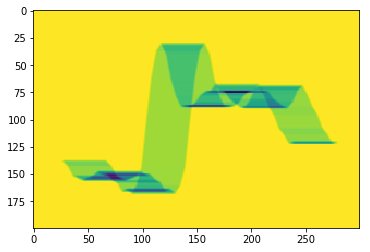

Applying a 70 pixels long Moving Average Filter


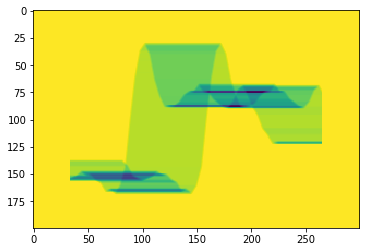

Applying a 100 pixels long Moving Average Filter


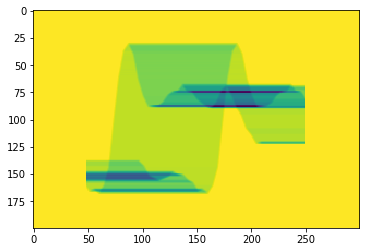

In [7]:
path = 'W:/Bureau/these/data/curves/all/Curvature/cryptophytes/2019-05-01 02h27_0.png'

print('Original image')
img = imread(path)
img = rgb2gray(img)
plt.imshow(img)
plt.show()

for ma_length in np.linspace(10, 100, 4):
    print('Applying a', int(ma_length), 'pixels long Moving Average Filter')
    ma_img = moving_average_batch(np.array([img]), int(ma_length))
    plt.imshow(ma_img[0])
    plt.show()

## Train a supervised Convolutional Neural Network on the curves

The next two cells take times to run. You need to run them only the first time you run this notebook on your computer

In [ ]:
extract_imgs(data_source, data_destination, max_cc_instance_per_date = 2000, noise_pcles_to_load =  2 * (10 ** 6))

In [3]:
# Split the curves in three sub-directories
imgs_train_test_valid_split(root_dir, balanced = True, is_test_set = False) 

Curvature
FL Orange
FL Red
FWS
SWS


Describing the model used

In [3]:
model = cnn_model(nb_classes = 7)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 300)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200, 300)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200, 300)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 200, 300)     0                                            
__________________________________________________________________________________________________
input_5 (I

Fit the generators. For the moment the generatord only output existing images but rotated/flipped images can be generated. 

In this notebook no test set is considered.

In [4]:
shuffle = True # Shuffle the observations
ma = 40 # A 40 pixels long moving average is applied over the images

In [5]:
source_generator = ImageDataGenerator(horizontal_flip = True, rescale = 1./ 255) # Allow 180° rotations # rescale ? 
batch_size = 16
os.chdir(root_dir)

train_generator_dict = multi_input_gen(source_generator, 'train', batch_size, shuffle = shuffle)
valid_generator_dict = multi_input_gen(source_generator, 'valid', batch_size, shuffle = shuffle)

train_generator = fit_gen(train_generator_dict, ma = ma)
valid_generator = fit_gen(valid_generator_dict, ma = ma)


# Defining the number of steps in an epoch
nb_train, nb_test, nb_valid = nb_available_imgs(root_dir) # Compute the available images for each train, test and valid folder

STEP_SIZE_TRAIN = (nb_train // batch_size) + 1 
STEP_SIZE_VALID = (nb_valid // batch_size) + 1 

Found 189 images belonging to 7 classes.
Found 189 images belonging to 7 classes.
Found 189 images belonging to 7 classes.
Found 189 images belonging to 7 classes.
Found 189 images belonging to 7 classes.
Found 63 images belonging to 7 classes.
Found 63 images belonging to 7 classes.
Found 63 images belonging to 7 classes.
Found 63 images belonging to 7 classes.
Found 63 images belonging to 7 classes.


In [ ]:
print(STEP_SIZE_VALID)
for imgs, labels in valid_generator:
    plt.imshow(imgs[0][0])
    plt.show()
    print(imgs[0][0].dtype)
    break

Train the model

Epoch 1/5
12/12 [==============================] - 7s 567ms/step - loss: 2.4363 - acc: 0.1274 - val_loss: 2.2088 - val_acc: 0.1429
Epoch 2/5
12/12 [==============================] - 6s 486ms/step - loss: 2.2073 - acc: 0.1169 - val_loss: 2.0579 - val_acc: 0.1429
Epoch 3/5
12/12 [==============================] - 6s 520ms/step - loss: 2.1597 - acc: 0.1482 - val_loss: 2.0589 - val_acc: 0.1429
Epoch 4/5
12/12 [==============================] - 6s 506ms/step - loss: 2.1052 - acc: 0.1315 - val_loss: 2.0661 - val_acc: 0.1429
Epoch 5/5
12/12 [==============================] - 6s 503ms/step - loss: 2.0615 - acc: 0.1460 - val_loss: 2.0312 - val_acc: 0.1429


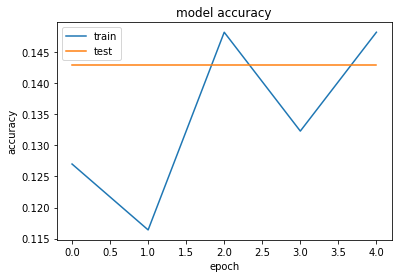

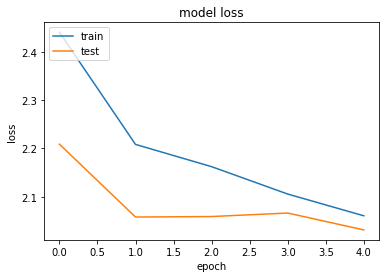

In [6]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 5
)


# General picture of the valid and train losses through the epochs:
plot_losses(history)

In [7]:
### Fetch the true labels of the test set
y_true = list(valid_generator_dict.values())[0].classes

## Get the predicted labels from the model
preds = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID)
y_pred = np.array([np.argmax(x) for x in preds])

In [8]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         9
          1       0.00      0.00      0.00         9
          2       0.00      0.00      0.00         9
          3       0.00      0.00      0.00         9
          4       0.14      1.00      0.25         9
          5       0.00      0.00      0.00         9
          6       0.00      0.00      0.00         9

avg / total       0.02      0.14      0.04        63



L:\ProgramData\Anaconda4\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The model seems to learn nothing and predict always the same class: 1/nb_groups = 0.1429...
The signal is too diluted